# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
MODULE_PATH = "C:\\Users\\Vicky Lin\\Documents\\tf_models\\research\\"

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
sys.path.append(MODULE_PATH)

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [20]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [7]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = os.path.join(MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_TF = "C:\\Users\\Vicky Lin\\Documents\\tf_models\\research\\object_detection"
PATH_TO_LABELS = os.path.join(PATH_TO_TF, 'data', 'mscoco_label_map.pbtxt')

## Download Model

In [ ]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [17]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [9]:
def load_image_into_numpy_array(image):
    if image.format != "JPEG" or image.mode != "RGB":
        image = image.convert("RGB")
    
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()

# Detection

In [11]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
TEST_IMAGES_ROOT = 'C:/Users/Vicky Lin/Documents/DM/H2/boat-types-recognition/'
TEST_IMAGE_DIRNAMES = ["buoy", "cruise ship", "ferry boat", "freight boat", "gondola", "inflatable boat", "kayak", "paper boat", "sailboat"]
TEST_IMAGE_BASES = [os.path.join(TEST_IMAGES_ROOT, dirname) for dirname in TEST_IMAGE_DIRNAMES]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

# Cropped image path
CROPPED_IMAGE_ROOT = os.path.join(os.getcwd(), "cropped")
if not os.path.isdir(CROPPED_IMAGE_ROOT): os.mkdir(CROPPED_IMAGE_ROOT)

In [15]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

## Specific images
Change `TEST_IMAGE_PATHS` to specify the path of images you want to detect.

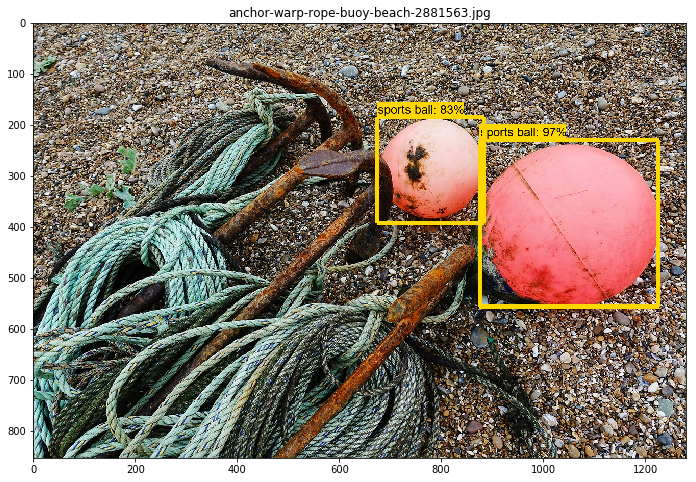

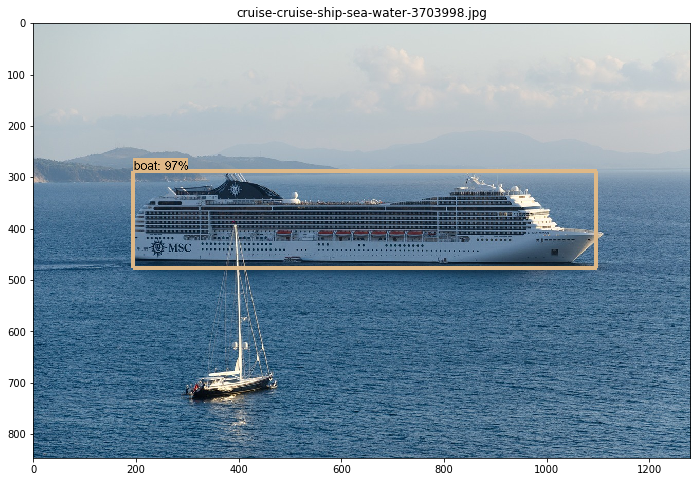

In [22]:
TEST_IMAGE_PATHS = ["C:\\Users\\Vicky Lin\\Documents\\DM\\H2\\boat-types-recognition\\buoy\\anchor-warp-rope-buoy-beach-2881563.jpg",
                    "C:\\Users\\Vicky Lin\\Documents\\DM\\H2\\boat-types-recognition\\cruise ship\\cruise-cruise-ship-sea-water-3703998.jpg"]

BOUNDING_BOXES = {}
CLASS = {}
SCORES = {}

count = 0
total = len(TEST_IMAGE_PATHS)

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

    # For cropping
    image_name = os.path.basename(image_path)
    BOUNDING_BOXES[image_name] = output_dict['detection_boxes']
    CLASS[image_name] = output_dict['detection_classes']
    SCORES[image_name]  = output_dict['detection_scores']

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)

    plt.figure(figsize=IMAGE_SIZE)
    plt.title(image_name)
    plt.imshow(image_np)

    count += 1
    writeProgress("Progress loading images: ", count, total)

## All images in the directory

In [ ]:
print("Detecting...")


for index, base in enumerate(TEST_IMAGE_BASES):
    TEST_IMAGE_PATHS = [os.path.join(base, filename) for filename in os.listdir(base) if filename.endswith(".jpg")]
    
    # filename: [bounding boxes]
    BOUNDING_BOXES = {}
    CLASS = {}
    SCORES = {}
    
    count = 0
    total = len(TEST_IMAGE_PATHS)
    
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

        # For cropping
        image_name = os.path.basename(image_path)
        BOUNDING_BOXES[image_name] = output_dict['detection_boxes']
        CLASS[image_name] = output_dict['detection_classes']
        SCORES[image_name]  = output_dict['detection_scores']

        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=8)

        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

        count += 1
        writeProgress("Progress loading " + image_name + " images: ", count, total)
    
    with open(TEST_IMAGE_DIRNAMES[index] + '-bounding.txt', 'w') as outfile:
            outfile.write(repr(BOUNDING_BOXES))

    with open(TEST_IMAGE_DIRNAMES[index] + '-class.txt', 'w') as outfile:
        outfile.write(repr(CLASS))

    with open(TEST_IMAGE_DIRNAMES[index] + '-score.txt', 'w') as outfile:
        outfile.write(repr(CLASS))

# Cropping

In [ ]:
THRESHOLD = 0.5

In [ ]:
def crop_image(image_filename, bounding, index=0):
    img = Image.open(os.path.join(TEST_IMAGE_BASE, image_filename))
        
    im_width, im_height = img.size
    ymin, xmin, ymax, xmax = tuple(bounding)
    bounding = (xmin * im_width, ymin * im_height, xmax * im_width, ymax * im_height)
    img = img.crop(bounding)

    name, ext = os.path.splitext(image_filename)
    img_path = os.path.join(CROPPED_IMAGE_DIRPATH, name + "-" + str(index) + ext)
    
    if img.format != "JPEG" or img.mode != "RGB":
        img = img.convert("RGB")
    img.save(img_path, quality=95)

In [ ]:
for filename, bounding_list in BOUNDING_BOXES.items(): 
    if 9 in CLASS[filename]:
        boat_indices = np.where(CLASS[filename] == 9)
        for i, boat_index in enumerate(boat_indices[0]):
            crop_image(filename, bounding_list[boat_index], i)
    else:
        for index, bounding in enumerate(bounding_list):
            if np.count_nonzero(bounding) == 0:
                continue
#             if SCORES[filename][index] > THRESHOLD:
#                 crop_image(filename, bounding, index)